*David Schlangen, 2019-03-24*

# Task: Object Naming

Naming the category that a given object belongs to is a language generation task that has a long tradition in psycholinguistics, where the time course of replying to stimuli with a name is used to test hypotheses about accessibility.

\cite{Glaser1992} provides an overview of some earlier work in this field, describing among other things the well-established finding that there is a discrepancy between reading a name out aloud, and providing it in response to a picture. A natural hypothesis for why that might be the case is that when reading out a category name (for which the word must be recognised), the name is fixed, but when naming (the category of an object in) a picture, the object must be recognised *and* one of the many applicable names must be selected for production.

In [1]:
# imports

from collections import Counter, defaultdict
import configparser
import os
import random
from textwrap import fill
import sys

from ipywidgets import widgets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display, clear_output

pd.set_option('max_colwidth', 250)

In [2]:
# Load up config file (needs path; adapt env var if necessary); local imports

# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../../clp-vision/Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = configparser.ConfigParser()
with open(config_path, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('../Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [3]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = ['saiapr_bbdf', 'saiapr_refdf', 'mscoco_bbdf', 'refcoco_refdf', 
            'mscoco_catsdf',
            'refcocoplus_refdf', 'grex_refdf',
            'vgregdf', 'vgimgdf', 'vgobjdf', 'vgreldf', 'vgattdf', 'vgvqadf',
            'vgpardf', 'cococapdf']
df = load_dfs(preproc_path, df_names)

# easier to look up:
cococat = dict(zip(df['mscoco_catsdf'].index, df['mscoco_catsdf']['cat'].values))

# a derived DF, containing only those region descriptions which I was able to resolve
df['vgpregdf'] = df['vgregdf'][df['vgregdf']['pphrase'].notnull() & 
                               (df['vgregdf']['pphrase'] != '')]

## The Task

Let's define *naming* as the task of finding a noun for a given object such that the noun names a class that the object belongs to. The way we have told the story so far, one might think that this just involves checking which of the sets $I_w(D)$ the object that is to be named is in, with $w$ ranging over all nouns in the vocabulary. (And looking at it from this perspective, this task reduces to answering polar questions of the "is this a(n) N?" type, for all N in the vocabulary.)

This certainly would be a start, but there is more to this task, at least as it is typically understood in psycholinguistics. Imagine you have the words "labradoodle", "dog", and "animal" in your vocabulary, and you are shown a picture of an entity which is in the extension of all these words, which of these is the appropriate category name? (The classic reference for this type of consideration being the work of Eleanor Rosch \cite{Rosch1978}, already briefly mentioned above.)

The addition then is *choice* of the best fitting expression, out of those that are semantically correct. This choice can be influenced by factors that lie within the speaker, but also by factors that lie in the context in which the object is found that is to be named, as well as the context in which the expression is produced.

To illustrate this, we can again look at the COCO category annotation (already seen above in [Nouns](#Nouns)). Here it is for a randomly selected image. We can see that the constraints discussed above arguably are not met here; it is rare that people are identified just as "person", and typically more specific expressions such as "woman", "boy", etc. are used.

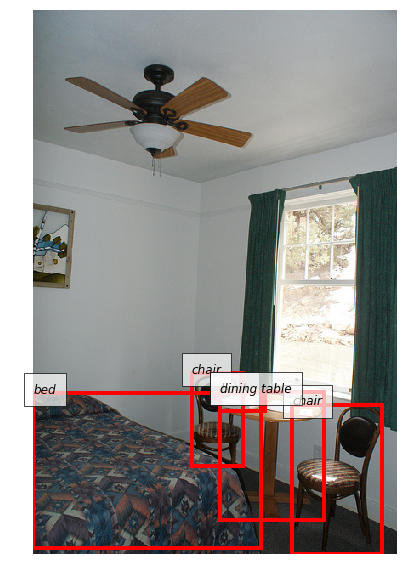

In [10]:
# plot mscoco categories on image
ic, ii = df['mscoco_bbdf'].sample()[['i_corpus', 'image_id']].values[0]
this_anno = query_by_id(df['mscoco_bbdf'], (ic, ii), ['bb', 'cat']).values
plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, cococat[cat]) for b, cat in this_anno], figsize=(10,10))

As discussed above, the set of categories used in COCO is rather small, and if only this set is used as vocabulary, the task is better described as *labelling* than as *naming*. 

Visual genome offers richer data here. We have already seen an example of names from visual genome above; for convenience, here is another one:

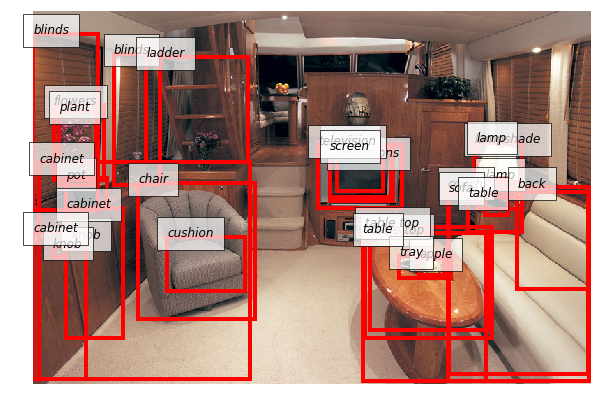

In [5]:
# plot all objects and names
pick_row = 3567
this_row = df['vgobjdf'].iloc[pick_row]
ic, ii = this_row['i_corpus image_id'.split()].values

plot_labelled_bb(get_image_filename(config, ic, ii),
                 query_by_id(df['vgobjdf'], (ic, ii), ['bb', 'name']).values)

## What Constrains Naming Choice?

Given that object names are normalised by reference to WordNet synsets, one might hope that this data could be used to shed light on the question of how, in a given context, a particular name is chosen for a given concept. The following shows the range of names that have been normalised to the same synset, for a few selected synsets.

In [6]:
# prepare mapping from synsets to names
synset2names = defaultdict(list)
_ = [synset2names[o].append(n) for o,n in df['vgobjdf'][['syn', 'name']].values]

synset2names = {syn: Counter(names) for syn, names in synset2names.items()}

In [7]:
# some example synsets
this_syn = 'chair.n.01'
print("-" * 30)
print(this_syn, 'realised as:')
for n,c in synset2names[this_syn].most_common()[:20]:
    print("{:>15} ({:>6,} times)".format(n, c))
    
this_syn = 'woman.n.01'
print("-" * 30)
print(this_syn, 'realised as:')
for n,c in synset2names[this_syn].most_common()[:20]:
    print("{:>15} ({:>6,} times)".format(n, c))

this_syn = 'bicycle.n.01'
print("-" * 30)
print(this_syn, 'realised as:')
for n,c in synset2names[this_syn].most_common()[:20]:
    print("{:>15} ({:>6,} times)".format(n, c))

------------------------------
chair.n.01 realised as:
          chair (12,842 times)
         chairs ( 1,362 times)
   wooden chair (   113 times)
  folding chair (    88 times)
     chair back (    76 times)
     high chair (    61 times)
  rocking chair (    60 times)
     blue chair (    60 times)
    black chair (    54 times)
      red chair (    49 times)
    white chair (    45 times)
    brown chair (    44 times)
    green chair (    25 times)
           seat (    24 times)
    empty chair (    22 times)
   dining chair (    20 times)
     two chairs (    15 times)
   white chairs (    12 times)
          couch (    11 times)
           sofa (    11 times)
------------------------------
woman.n.01 realised as:
          woman (33,402 times)
          women ( 1,025 times)
  smiling woman (   898 times)
         person (   248 times)
           lady (   180 times)
           girl (   164 times)
   woman's hand (    97 times)
   woman's head (    90 times)
        woman's (    6

As these examples illustrate, the process of identifying the names in the larger region descriptions oftens seems to have captured not just the noun, but also adjectives and numerals. Second, as already remarked upon above in connection with the relations, the normalisation process is also not always fully reliable (e.g., when normalising "motorcycle" as `bicycle.n.01`). This must be kept in mind when trying to learn realisation principles from this mapping.

* **Dataset:** Nouns + image objects
* **Source:** visual genome
* **Uses:** learn naming function (from object [possibly in context] to name)

## Scene Context

The task of naming also lends itself to an investigation of the general effect of context on categorisation. It is a well-known effect that context matters, and that the same pixels can be classified very differently, when placed in different scene contexts (see review in \cite{Bar2004}). We can learn from the corpora which objects typically occur together, and in which configurations; this can then be used to turn the task into one of finding the best *joint* naming of all objects in a scene.

The following shows an image where only the sizes and locations of bounding boxes are preserved, and the (category) identities of all objects except one target object (overlapping with the "chair"). Even if one cannot perfectly guess what that target object may be (a cat? a cushion?), the choice still seems more constrained than random (it's probably not a bus). 

(But note that the real task, as mentioned above, would be one of jointly predicting the most likely range of categories for all objects in the scene, given visual information about each. From that range, the naming process can then choose one candidate, using different principles.)

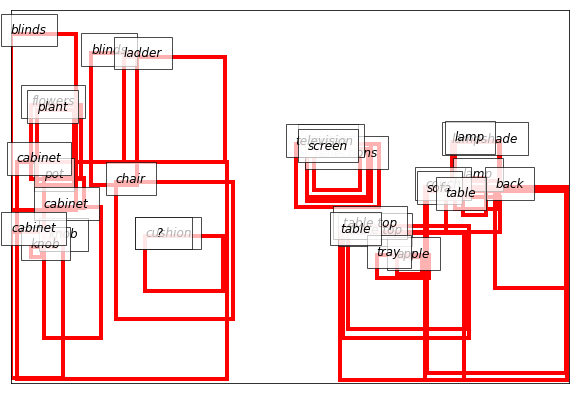

In [8]:
# plot all objects and names, but no visual information
pick_row = 3567
this_row = df['vgobjdf'].iloc[pick_row]
ic, ii = this_row['i_corpus image_id'.split()].values

bbs = query_by_id(df['vgobjdf'], (ic, ii), ['bb', 'name'])
bbs = list(bbs.values) + [(bbs[bbs.index == 3565]['bb'].values[0], '   ?     ')]

plot_labelled_bb(get_image_filename(config, ic, ii),
                 bbs,
                 show_image=False)

* **Dataset:** Nouns + image objects
* **Source:** visual genome, mscoco (via refcoco), saiapr
* **Uses:** learn scene constraints

Output()

VBox(children=(HBox(children=(ToggleButton(value=False, description='flowers'), ToggleButton(value=False, description='pot'), ToggleButton(value=False, description='lampshade'), ToggleButton(value=False, description='lamp'), ToggleButton(value=False, description='chair'))), HBox(children=(ToggleButton(value=False, description='blinds'), ToggleButton(value=False, description='blinds'), ToggleButton(value=False, description='knob'), ToggleButton(value=False, description='knob'), ToggleButton(value=False, description='cabinet'))), HBox(children=(ToggleButton(value=False, description='cabinet'), ToggleButton(value=False, description='couch'), ToggleButton(value=False, description='reflections'), ToggleButton(value=False, description='screen'), ToggleButton(value=False, description='table top'))), HBox(children=(ToggleButton(value=False, description='back'), ToggleButton(value=False, description='apple'), ToggleButton(value=False, description='table top'), ToggleButton(value=False, description='television'), ToggleButton(value=False, description='screen'))), HBox(children=(ToggleButton(value=False, description='cushion'), ToggleButton(value=False, description='sofa'), ToggleButton(value=False, description='lamp'), ToggleButton(value=False, description='table'), ToggleButton(value=False, description='ladder')))))

Button(description='Redraw', style=ButtonStyle())

Button(description='Clear All', style=ButtonStyle())

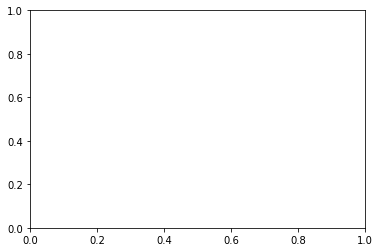

In [11]:
# just for fun, with widgets that switch bbs on and off
# haven't been able to remove the spurious empty figure below...

pick_row = 3567
this_row = df['vgobjdf'].iloc[pick_row]
ic, ii = this_row['i_corpus image_id'.split()].values

bbs = query_by_id(df['vgobjdf'], (ic, ii), ['bb', 'name'])

bb_map = {}

h_max = 5
rows = []
this_row = []

#plt.ioff()
ax = plt.gca()
fig = plt.gcf()
#fig.set_size_inches((1,1))

for n, row in bbs.iterrows():
    this_button = widgets.ToggleButton(value=False,
                                       description=row['name'],
                                       disabled=False,
                                       button_style='')
    bb_map[n] = [this_button, row['bb'], row['name']]
    this_row.append(this_button)
    if (n+1) % h_max == 0:
        rows.append(widgets.HBox(this_row))
        this_row = []
        
out = widgets.Output()
rows_layouted = widgets.VBox(rows)
redraw_button = widgets.Button(description='Redraw')
clear_button = widgets.Button(description='Clear All')

def click(b):
    bbs = [(e[1], e[2]) for e in bb_map.values() if e[0].value]
    # print bbs
    # print ax
    ax.clear()
    with out:
        clear_output(wait=True)
        plot_labelled_bb(get_image_filename(config, ic, ii), bbs, show_image=False, 
                         ax=ax)
        display(ax.figure)
    return bbs

def clear(b):
    for button, _, _ in bb_map.values():
        button.value = False
    click(None)
    
redraw_button.on_click(click)
clear_button.on_click(clear)

display(out, rows_layouted, redraw_button, clear_button)

# References

[<a id="cit-Glaser1992" href="#call-Glaser1992">1</a>] Glaser Wilhelm R, ``_Picture naming_'', Cognition, vol. 42, number 1, pp. 61--105,  1992.

[<a id="cit-Rosch1978" href="#call-Rosch1978">2</a>] Eleanor Rosch, ``_Principles of Categorization_'',  1978.

[<a id="cit-Bar2004" href="#call-Bar2004">3</a>] Bar Moshe, ``_Visual Objects In Context_'', Nature Reviews Neuroscience, vol. 5, number , pp. 617--629,  2004.

